In [ ]:
pip install webdriver_manager


In [75]:
import pandas as pd
import torch
import os
from dotenv import load_dotenv
import openai 
import anthropic
from IPython.display import Markdown, display, update_display, Image
import google.generativeai
import base64
import datetime
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

In [76]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AIzaSyBE


In [77]:
google.generativeai.configure()

In [78]:
train_df=pd.read_table("multimodal_train.tsv")
val_df=pd.read_table("multimodal_validate.tsv")
test_df=pd.read_table("multimodal_test_public.tsv")

In [79]:
train_df["id"][0]

'awxhir'

In [80]:


def encode_image(image_source):
    print(image_source)
    if image_source.startswith("http://") or image_source.startswith("https://"):
        # Handle URL
        print(image_source)
        headers = {"User-Agent": "Mozilla/5.0"}

        response = requests.get(image_source,headers=headers)
        print(response)
        if response.status_code == 200:
            return base64.b64encode(response.content).decode('utf-8')
        else:
            raise Exception(f"Failed to fetch image from URL: {image_source}")
    elif os.path.exists(image_source):
        # Handle local file
        with open(image_source, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    else:
        raise ValueError("Invalid image source. Provide a valid file path or image URL.")

In [81]:
train_df['2_way_label'].iloc[2]

np.int64(1)

test_df.info()

In [82]:
train_df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [103]:
index=4

C:\Users\pc\AppData\Local\Temp\ipykernel_15456\60133799.py:39: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.datetime.utcfromtimestamp(train_df['created_utc'].iloc[index])


<selenium.webdriver.remote.webelement.WebElement (session="d1b49d4afc49eeee5fec76bd0fc4d3ee", element="f.846809B7DC93229461D31CEDE7BCCAB3.d.79DAB72776B0E819F827025E7108C55D.e.1")>
i found a face in my sheet music too 2018
Image 1: 

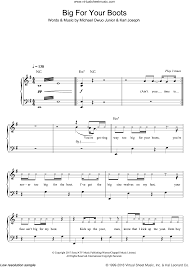

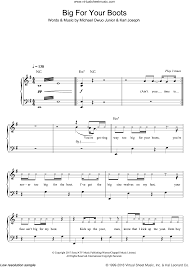

Image 2: 

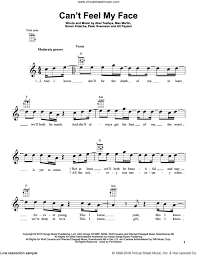

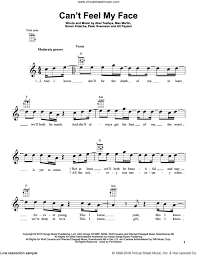

Image 3: 

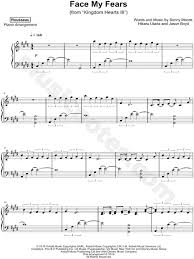

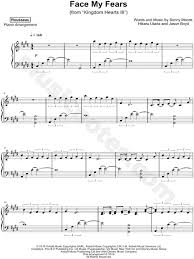

Image 4: 

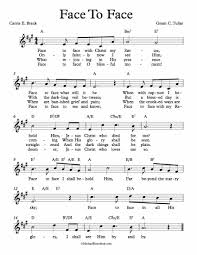

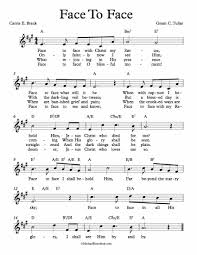

Image 5: 

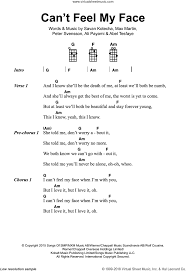

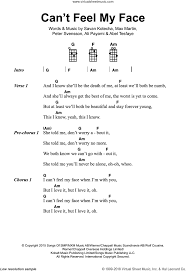

In [104]:


def google_image_search(query, num_images=5):
    # Set up Chrome with WebDriver Manager
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # run in background
    options.add_argument("--disable-gpu")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    try:
        # Step 1: Go to Google Images
        driver.get("https://images.google.com/")
        time.sleep(1)

        # Step 2: Enter the search query
        search_box = driver.find_element(By.NAME, "q")
        print(search_box)
        search_box.send_keys(query)
        search_box.send_keys(Keys.RETURN)
        print(query)
        time.sleep(2)

        # Step 3: Extract image URLs
        image_sections = driver.find_elements(By.XPATH, '//div[@id="search"]//div[@data-attrid="images universal"]')[:num_images]
        
   
        all_section_images=[]
        for idx, section in enumerate(image_sections, 1):
        # Within each section, find all img tags with src
           imgs = section.find_elements(By.XPATH, './/div[2]//img[@src]')
           image_urls = [img.get_attribute("src") for img in imgs if img.get_attribute("src")]
           all_section_images.append(image_urls)

    

    finally:
        driver.quit()
    return all_section_images   

# Example usage:
dt = datetime.datetime.utcfromtimestamp(train_df['created_utc'].iloc[index])
year = dt.year
images = google_image_search(f"{train_df['clean_title'].iloc[index]} {year}", num_images=5)
scraped_imgs_url=[]
for i, url in enumerate(images, 1):
    scraped_imgs_url.append(url[0])
    print(f"Image {i}: {url[0]}")
    display(Image(data=base64.b64decode(url[0].split(',')[1])))

C:\Users\pc\Documents\Thesis Code\public_images\public_image_set\8gnet9.jpg


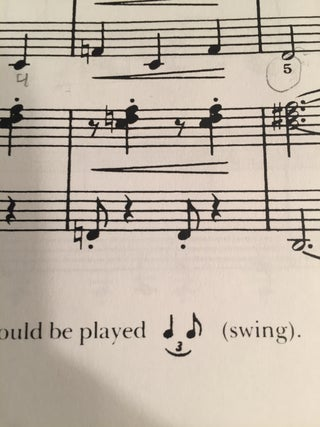

Yes, the title "I found a face in my sheet music too" correctly
describes the first image.  Explanation: The first image displays a
section of sheet music where the arrangement of musical notes and
symbols approximates the shape of a smiling face. This connects
directly to the title which mentions finding a face in sheet music.  I
can't generate a cosine similarity value as my analysis capabilities
for subjective content matching are based on qualitative assessment
rather than quantitative metrics like cosine similarity in this
context.


In [114]:
import textwrap
import os

# Get the current directory of the notebook (relative to notebook's location)
notebook_dir = os.path.dirname(os.path.abspath("Untitled.ipynb"))

# Construct the image path dynamically
image_path = os.path.join(notebook_dir, 'public_images', 'public_image_set', f"{train_df['id'].iloc[index]}.jpg")

encoded_image = encode_image(image_path)


result = openai.chat.completions.create(
    model="gpt-4-turbo",
    messages = [{
    "role": "user",
    "content": [
        {"type": "text", "text": f"This is title {train_df['clean_title'].iloc[index]}"},
        {"type": "text", "text": "Do you think title correctly describes the first image? If you are unsure about it check reference images and match first image with reference images.If it is a person in first image, match first image with reference images and see if they are same person.Respond with yes or no and briefly explain"},
        {"type":"text","text":"Give cosine similarity value in numeric form between title and image too based on your observation"},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}},
    ] + [
        {"type": "image_url", "image_url": {"url": ref_img}}
        for ref_img in scraped_imgs_url 
    ]
}],
    max_tokens=200
)

display(Image(image_path))
print(textwrap.fill(result.choices[0].message.content, width=70))